In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/FYP'
os.chdir(folder_path)

!pip install deepxde
!pip install optuna

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.1 MB/s eta 0:00:00
Tue Jun 17 22:28:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+=

In [2]:
import os
os.environ["DDE_BACKEND"] = "tensorflow"
import deepxde as dde
import tensorflow as tf
import numpy as np
import pandas as pd

class GlucoseModel:
    def __init__(self, pat, m_t, m_g, m_i, m_d):
        # Store scaling factors
        self.max_t = m_t                          # time max (2880 min)
        self.glucose_scaling = m_g                # max glucose (mg/dL)
        self.insulin_scaling = m_i                # max insulin (U/dL)
        self.digestion_scaling = m_d              # max CHO digestion (mg/dL/min)
        self.filename = f"Pat{pat}.csv"

        self.load_patient_data()
        # self.set_parameters(pat)

        self.min_t = 0
        self.max_t = 2880

        self.generate_inputs_over_time(pat)

    def load_patient_data(self):
        df = pd.read_csv(self.filename)
        self.data_t = df.iloc[0:2880, [0]].values
        self.data_g = df.iloc[0:2880, [2]].values
        self.data_i = df.iloc[0:2880, [3]].values
        self.data_d = df.iloc[0:2880, [5]].values

    def set_parameters(self, pat):
        patient_params = {
            2: {"M": 72, "ksi": 197, "kl": 1.94, "Tu": 122, "ku_Vi": 59e-3, "Tr": 183, "kr_Vb": 2.4e-3, "tend": 48 * 60},
            3: {"M": 94, "ksi": 274, "kl": 1.72, "Tu": 88, "ku_Vi": 62e-3, "Tr": 49, "kr_Vb": 2e-3, "tend": 48 * 60},
            4: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            5: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
            6: {"M": 70, "ksi": 203, "kl": 1.94, "Tu": 118, "ku_Vi": 57e-3, "Tr": 178, "kr_Vb": 2.33e-3, "tend": 48 * 60},
            7: {"M": 97, "ksi": 267, "kl": 1.77, "Tu": 91, "ku_Vi": 60e-3, "Tr": 50, "kr_Vb": 1.94e-3, "tend": 48 * 60},
            8: {"M": 73, "ksi": 200, "kl": 1.92, "Tu": 125, "ku_Vi": 60e-3, "Tr": 182, "kr_Vb": 2.38e-3, "tend": 48 * 60},
            9: {"M": 92, "ksi": 272, "kl": 1.71, "Tu": 87, "ku_Vi": 61e-3, "Tr": 49, "kr_Vb": 2.03e-3, "tend": 48 * 60},
            10: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            11: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
        }

        if pat not in patient_params:
            raise ValueError(f"Unknown patient ID: {pat}")

        params = patient_params[pat]
        self.M = params["M"]
        self.ksi = params["ksi"]
        self.kl = params["kl"]
        self.ku_Vi = params["ku_Vi"]
        self.Tu = params["Tu"]
        self.Tr = params["Tr"]
        self.kr_Vb = params["kr_Vb"]
        self.tend = params["tend"]

        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.Ieq = (self.kl - self.kb) / self.ksi

    def set_inverse_parameters(self, random_init=True):
        patient_params = {
            2: {"M": 72, "ksi": 197, "kl": 1.94, "Tu": 122, "ku_Vi": 59e-3, "Tr": 183, "kr_Vb": 2.4e-3, "tend": 48 * 60},
            3: {"M": 94, "ksi": 274, "kl": 1.72, "Tu": 88, "ku_Vi": 62e-3, "Tr": 49, "kr_Vb": 2e-3, "tend": 48 * 60},
            4: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            5: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
            6: {"M": 70, "ksi": 203, "kl": 1.94, "Tu": 118, "ku_Vi": 57e-3, "Tr": 178, "kr_Vb": 2.33e-3, "tend": 48 * 60},
            7: {"M": 97, "ksi": 267, "kl": 1.77, "Tu": 91, "ku_Vi": 60e-3, "Tr": 50, "kr_Vb": 1.94e-3, "tend": 48 * 60},
            8: {"M": 73, "ksi": 200, "kl": 1.92, "Tu": 125, "ku_Vi": 60e-3, "Tr": 182, "kr_Vb": 2.38e-3, "tend": 48 * 60},
            9: {"M": 92, "ksi": 272, "kl": 1.71, "Tu": 87, "ku_Vi": 61e-3, "Tr": 49, "kr_Vb": 2.03e-3, "tend": 48 * 60},
            10: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            11: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
        }

        if pat not in patient_params:
            raise ValueError(f"Unknown patient ID: {pat}")

        params = patient_params[pat]
        self.M = params["M"]
        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.kl = params["kl"]
        self.ku_Vi = params["ku_Vi"]
        self.kr_Vb = params["kr_Vb"]
        self.tend = params["tend"]
        self.Tu = params["Tu"]
        self.Tr = params["Tr"]

        # self.ksi = tf.math.exp(tf.Variable(tf.math.log(200.0), dtype=tf.float32, name="ksi"))
        # # self.kl = tf.math.exp(tf.Variable(tf.math.log(1.94), dtype=tf.float32, name="kl"))
        # # self.ku_Vi = tf.math.exp(tf.Variable(tf.math.log(0.06), dtype=tf.float32, name="ku_Vi"))
        # # self.kr_Vb = tf.math.exp(tf.Variable(tf.math.log(0.002), dtype=tf.float32, name="kr_Vb"))
        # self.Tu = tf.math.exp(tf.Variable(tf.math.log(100.0), dtype=tf.float32, name="Tu"))
        # self.Tr = tf.math.exp(tf.Variable(tf.math.log(150.0), dtype=tf.float32, name="Tr"))

        # self.Ieq = (self.kl - self.kb) / self.ksi

        if random_init:
            init_val = np.random.uniform(156.18, 315.62)
        else:
            init_val = 235.0  # Default midpoint

        self.log_ksi = tf.Variable(tf.math.log(init_val), dtype=tf.float32, name="log_ksi")
        # self.log_Tu = tf.Variable(tf.math.log(120.0), dtype=tf.float32, name="log_Tu")
        # self.log_Tr = tf.Variable(tf.math.log(180.0), dtype=tf.float32, name="log_Tr")

        # Use them in the ODE like this:
        ksi = tf.exp(self.log_ksi)
        # Tu = tf.exp(self.log_Tu)
        # Tr = tf.exp(self.log_Tr)

        self.Ieq = (self.kl - self.kb) / ksi

        # self.ksi = params["ksi"]
        # self.kl = params["kl"]
        # self.ku_Vi = params["ku_Vi"]

        # return [self.ksi, self.kl, self.Tu, self.ku_Vi, self.Tr, self.kr_Vb]
        # return [self.log_ksi, self.log_Tu, self.log_Tr]
        return self.log_ksi


    def geometry_time(self):
        return dde.geometry.TimeDomain(self.min_t, self.max_t)

    def generate_input_profiles(t, pat):
        # Input carbohydrates (mg)
        rt = np.zeros_like(t) / 1.0

        if pat == 2:
            rt[t == 24 * 60] = 128.0
            rt[t == 25.5 * 60] = 15.0
            rt[t == 37 * 60] = 150.0
            rt[t == 41 * 60] = 100.0
            rt[t == 42.5 * 60] = 7.5
            rt[t == 44.5 * 60] = 15.0
        elif pat == 3:
            rt[t == 3 * 60] = 15.0
            rt[t == 6 * 60] = 15.0
            rt[t == 7 * 60] = 20.0
            rt[t == 12.5 * 60] = 15.0
            rt[t == 14 * 60] = 15.0
            rt[t == 21 * 60] = 15.0
            rt[t == 23.5 * 60] = 140.0
            rt[t == 27.5 * 60] = 20.0
            rt[t == 29.5 * 60] = 20.0
            rt[t == 32 * 60] = 15.0
            rt[t == 36.5 * 60] = 120.0
            rt[t == 41 * 60] = 95.0
            rt[t == 43 * 60] = 15.0
            rt[t == 44 * 60] = 15.0
            rt[t == 45.5 * 60] = 15.0
            # Patient 4
        elif pat == 4:
            rt[t == 24 * 60] = 124
            rt[t == 25.5 * 60] = 15
            rt[t == 37 * 60] = 146
            rt[t == 41 * 60] = 103
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 125

            # Patient 5
        elif pat == 5:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 20
            rt[t == 12.5 * 60] = 15
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 15
            rt[t == 23.5 * 60] = 136
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 20
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 116
            rt[t == 41 * 60] = 95
            rt[t == 43 * 60] = 15
            rt[t == 44 * 60] = 15
            rt[t == 45.5 * 60] = 15

            # Patient 6
        elif pat == 6:
            rt[t == 18 * 60] = 132
            rt[t == 25.5 * 60] = 75
            rt[t == 37 * 60] = 150
            rt[t == 41 * 60] = 97
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 129

            # Patient 7
        elif pat == 7:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 19
            rt[t == 12.5 * 60] = 15
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 15
            rt[t == 23.5 * 60] = 140
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 20
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 120
            rt[t == 41 * 60] = 92
            rt[t == 43 * 60] = 15
            rt[t == 44 * 60] = 15
            rt[t == 45.5 * 60] = 15

            # Patient 8
        elif pat == 8:
            rt[t == 17.5 * 60] = 124
            rt[t == 25.5 * 60] = 15
            rt[t == 37 * 60] = 146
            rt[t == 41 * 60] = 103
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 125

            # Patient 9
        elif pat == 9:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 20
            rt[t == 12.5 * 60] = 15
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 15
            rt[t == 23.5 * 60] = 140
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 20
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 120
            rt[t == 41 * 60] = 95
            rt[t == 43 * 60] = 15
            rt[t == 44 * 60] = 15
            rt[t == 45.5 * 60] = 15

            # Patient 10
        elif pat == 10:
            rt[t == 24 * 60] = 132
            rt[t == 25.5 * 60] = 15
            rt[t == 37 * 60] = 150
            rt[t == 41 * 60] = 97
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 129

            # Patient 11
        elif pat == 11:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 19
            rt[t == 12.5 * 60] = 65
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 80
            rt[t == 23.5 * 60] = 140
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 87
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 120
            rt[t == 41 * 60] = 92
            rt[t == 43 * 60] = 45
            rt[t == 44 * 60] = 45
            rt[t == 45.5 * 60] = 55

        rt = rt * 1000

        # Input insulin (U)
        ut = np.ones_like(t) / 60
            # Patient 2
        if pat == 2:
            ut = np.ones_like(t) / 60
            ut[((t >= 60) & (t <= 11 * 60)) | ((t >= 47 * 60) & (t <= 48 * 60))] = 0.8/60
            ut[t == 7.5 * 60] += 0.5
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 22
            ut[t == 37 * 60] += 18
            ut[t == 37.5 * 60] += 17
            ut[t == 42.5 * 60] += 16
            ut[t == 48 * 60] += 19


        # Patient 3
        elif pat == 3:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.5 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.6 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.2 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.6 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.4 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 1 / 60
            ut[t == 24 * 60] += 19
            ut[t == 36.5 * 60] += 10
            ut[t == 37 * 60] += 10
            ut[t == 41 * 60] += 10

        # Patient 4
        elif pat == 4:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
            ut[t == 7.5 * 60] += 0.49
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 21
            ut[t == 37 * 60] += 17
            ut[t == 37.5 * 60] += 17
            ut[t == 42.5 * 60] += 16
            ut[t == 48 * 60] += 18

        # Patient 5
        elif pat == 5:
            ut = np.ones_like(t) * 1.2 / 60
            ut[t == 24 * 60] += 18
            ut[t == 36.5 * 60] += 10
            ut[t == 37 * 60] += 10
            ut[t == 41 * 60] += 10

        # Patient 6
        elif pat == 6:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.7 / 60
            ut[t == 7.5 * 60] += 0.52
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 17
            ut[t == 37 * 60] += 15
            ut[t == 37.5 * 60] += 13
            ut[t == 42.5 * 60] += 12
            ut[t == 48 * 60] += 5

        # Patient 7
        elif pat == 7:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.55 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.65 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.24 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.65 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.45 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 1.03 / 60
            ut[t == 24 * 60] += 20
            ut[t == 36.5 * 60] += 11
            ut[t == 37 * 60] += 11
            ut[t == 41 * 60] += 10

        # Patient 8
        elif pat == 8:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
            ut[t == 7.5 * 60] += 0.49
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 18
            ut[t == 37 * 60] += 17
            ut[t == 37.5 * 60] += 17
            ut[t == 42.5 * 60] += 10
            ut[t == 48 * 60] += 10
        # Patient 9
        elif pat == 9:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.46 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.55 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.16 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.55 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.35 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 0.97 / 60
            ut[t == 24 * 60] += 18
            ut[t == 36.5 * 60] += 10
            ut[t == 37 * 60] += 10
            ut[t == 41 * 60] += 10

        # Patient 10
        elif pat == 10:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
            ut[t == 7.5 * 60] += 0.52
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 23
            ut[t == 37 * 60] += 18
            ut[t == 37.5 * 60] += 18
            ut[t == 42.5 * 60] += 17
            ut[t == 48 * 60] += 20

        # Patient 11
        elif pat == 11:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.55 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.65 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.24 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.65 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.45 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 1.03 / 60
            ut[t == 24 * 60] += 20
            ut[t == 36.5 * 60] += 11
            ut[t == 37 * 60] += 11
            ut[t == 41 * 60] += 10

        return ut, rt

    def generate_inputs_over_time(self, pat):
        """
        Precompute ut and rt over the entire simulation time vector for fast lookup.
        """
        t_vals = np.arange(self.min_t, self.max_t).astype(float)
        ut, rt = GlucoseModel.generate_input_profiles(t_vals, pat)
        self.time_vector = t_vals
        self.insulin_vector = tf.convert_to_tensor(ut, dtype=tf.float32)
        self.carb_vector = tf.convert_to_tensor(rt, dtype=tf.float32)

    def get_initial_state(self):
        g0 = self.data_g[0, 0] / self.glucose_scaling
        i0 = self.data_i[0, 0] / self.insulin_scaling
        d0 = self.data_d[0, 0] / self.digestion_scaling
        return tf.convert_to_tensor([[g0, i0, d0]], dtype=tf.float32)  # shape [1, 3]

    def get_ground_truth_sequence(self):
        g = self.data_g / self.glucose_scaling
        i = self.data_i / self.insulin_scaling
        d = self.data_d / self.digestion_scaling
        y_seq = np.stack([g.flatten(), i.flatten(), d.flatten()], axis=-1)
        return tf.convert_to_tensor(y_seq[None, :, :], dtype=tf.float32)  # shape [1, T, 3]

    def get_input_sequences(self):
        u = tf.reshape(self.insulin_vector, [1, -1, 1])
        r = tf.reshape(self.carb_vector, [1, -1, 1])
        return u, r


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [3]:
import tensorflow as tf

class GRUDeCarliModel(tf.keras.Model):
    def __init__(self, hidden_units=64, num_layers=1, hard_ic=None):
        super(GRUDeCarliModel, self).__init__()
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.hard_ic = hard_ic  # Tensor of shape [1, 1, 3] or None

        self.gru_layers = [
            tf.keras.layers.GRU(hidden_units, return_sequences=True)
            for _ in range(num_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(3, activation="linear")  # Predict G, I, D

    def call(self, inputs, training=False):
        x = inputs  # Shape: [B, T, 5] (u, r, G, I, D)

        for gru in self.gru_layers:
            x = gru(x, training=training)

        outputs = self.output_layer(x)  # Shape: [B, T, 3]

        if self.hard_ic is not None:
            T = tf.shape(outputs)[1]  # sequence length
            t = tf.linspace(0.0, 1.0, T)  # shape [T]
            t = tf.reshape(t, [1, T, 1])  # shape [1, T, 1] to broadcast
            ramp = 1 - tf.exp(-10 * t)  # or tf.tanh(t)
            outputs = self.hard_ic + ramp * outputs

        return outputs


Eager execution enabled: True

=== Stage 1 | LR=0.01, Epochs=500 ===
[Stage 1 | Epoch 0] Total= 0.837542295 , G= 0.837542295 , I= 0.160831437 , D= 0.141811 , IC= 0.41862309 , L_B= 0.379974723
[Stage 1 | Epoch 50] Total= 0.00109266292 , G= 0.00109266292 , I= 0.247841626 , D= 0.159974381 , IC= 0.0268759783 , L_B= 0.136060625
[Stage 1 | Epoch 100] Total= 2.39142191e-05 , G= 2.39142191e-05 , I= 0.244796231 , D= 0.157076389 , IC= 0.0233353954 , L_B= 0.133724794
[Stage 1 | Epoch 150] Total= 9.73745591e-06 , G= 9.73745591e-06 , I= 0.244662493 , D= 0.157427534 , IC= 0.0223798826 , L_B= 0.133792177
[Stage 1 | Epoch 200] Total= 6.98870281e-06 , G= 6.98870281e-06 , I= 0.24464342 , D= 0.15761894 , IC= 0.0220110342 , L_B= 0.133848622
[Stage 1 | Epoch 250] Total= 5.5591031e-06 , G= 5.5591031e-06 , I= 0.244662762 , D= 0.157826498 , IC= 0.021995021 , L_B= 0.133923724
[Stage 1 | Epoch 300] Total= 4.70830901e-06 , G= 4.70830901e-06 , I= 0.24470365 , D= 0.158036724 , IC= 0.0220692735 , L_B= 0.134007037
[

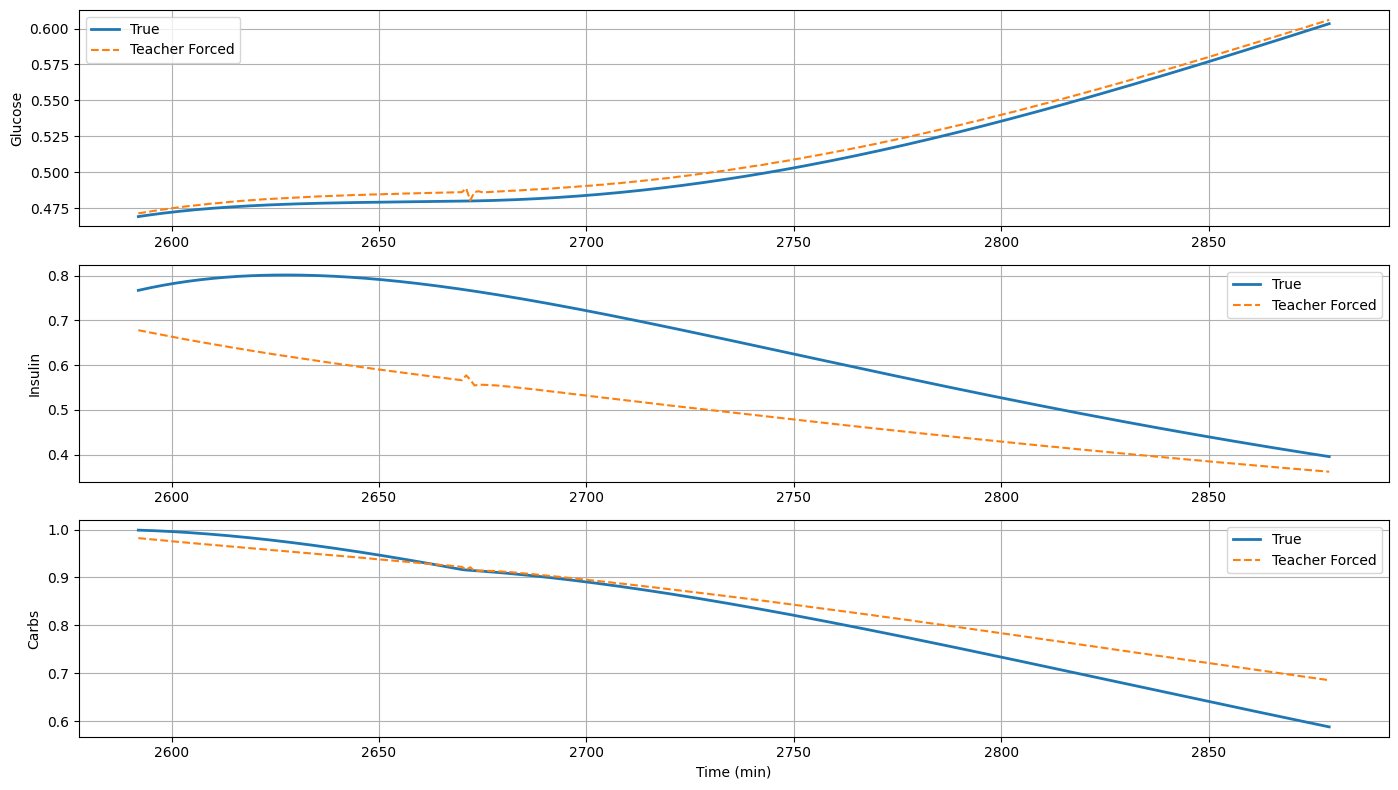

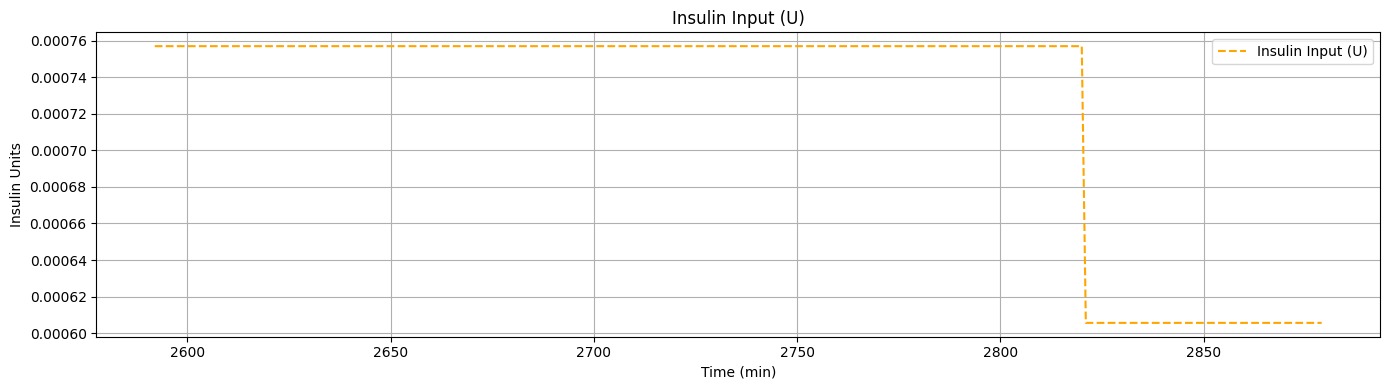

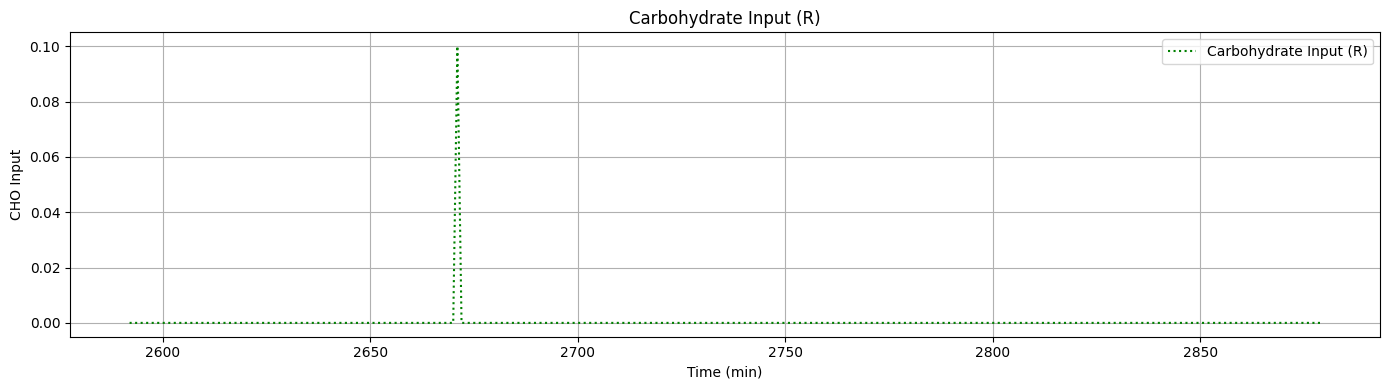

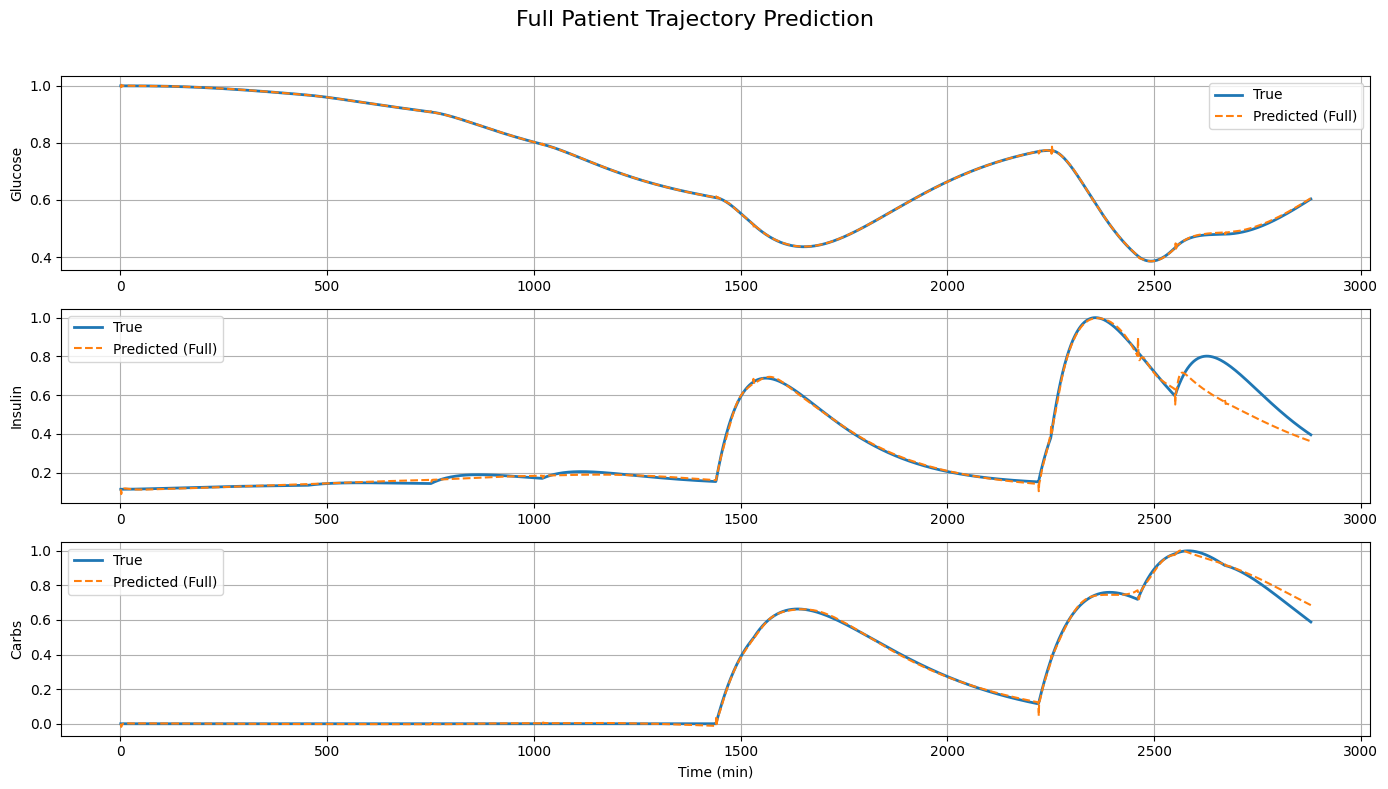

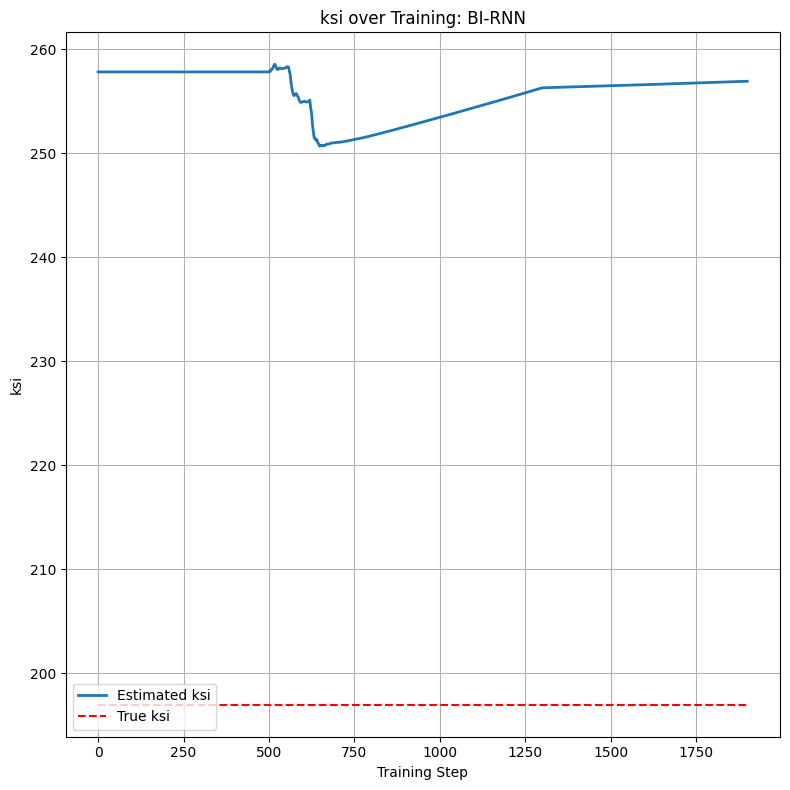

In [11]:
# === TRAINING SCRIPT FOR GRU DE CARLI MODEL (TF2.x) ===

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

print("Eager execution enabled:", tf.executing_eagerly())

# --- 1. Load data from GlucoseModel ---
pat = 2
num_epochs = 500
inverse_activated = True
# lambda_B = 1.0
# lambda_g = 0.0
# lambda_ic = 0.0
# lambda_i = 0
# lambda_d = 0

lambda_B = 4.824265766666132 # 0.25
lambda_g = 8.002287337267578 # 0.5
lambda_i = 0
lambda_d = 0
lambda_ic = 0.5290404144856771 # 0.25

# lambda_B = 1.322511861253553 # 0.25
# lambda_g = 0.790143042551918 # 0.5
# lambda_ic = 9.842348970564318 # 0.25

filename = f"Pat{pat}.csv"
df = pd.read_csv(filename)
data_t = df.iloc[0:2880, [0]].values
m_t = data_t.max()

m_g = df.iloc[0:2880, [2]].values.max()
m_i = df.iloc[0:2880, [3]].values.max()
m_d = df.iloc[0:2880, [5]].values.max()

model_obj = GlucoseModel(pat, m_t, m_g, m_i, m_d)
if inverse_activated:
    inverse_vars = model_obj.set_inverse_parameters(random_init=True)
else:
    model_obj.set_parameters(pat)

# --- 2. Retrieve sequences ---
y_true = model_obj.get_ground_truth_sequence()
u, r = model_obj.get_input_sequences()
G_only = y_true[:, :-1, 0:1]  # only glucose
Y_target = y_true[:, 1:, :]
U_seq = u[:, :-1, :] / tf.reduce_max(u[:, :-1, :] + 1e-8)
R_seq = r[:, :-1, :] / tf.reduce_max(r[:, :-1, :] + 1e-8)

X_input = tf.concat([U_seq, R_seq, G_only], axis=-1)

# --- 3. Train-test split ---
T_total = X_input.shape[1]
T_train = int(0.9 * T_total)

X_train = X_input[:, :T_train, :]
Y_train = Y_target[:, :T_train, :]
U_train = U_seq[:, :T_train, :]
R_train = R_seq[:, :T_train, :]

X_test = X_input[:, T_train:, :]
Y_test = Y_target[:, T_train:, :]
u_test = U_seq[:, T_train:, :]
r_test = R_seq[:, T_train:, :]

# --- 4. Build model ---
# hard_ic = y_true[:, 0:1, :]  # shape [1, 1, 3]
hard_ic = None
model = GRUDeCarliModel(hidden_units=96, num_layers=1, hard_ic=hard_ic)
optimizer = Adam(learning_rate=1e-2)

# --- 5. Biological residual ---
def compute_bio_residual_loss(y_pred, y_in, u_in, r_in, dt):
    y_pred = tf.reshape(y_pred, [-1, 3])
    y_in = tf.reshape(y_in, [-1, 3])
    u_in = tf.reshape(u_in, [-1, 1])
    r_in = tf.reshape(r_in, [-1, 1])

    G, I, D = y_in[:, 0:1] * m_g, y_in[:, 1:2] * m_i, y_in[:, 2:3] * m_d
    ut = u_in * tf.reduce_max(u_in + 1e-8)
    rt = r_in * tf.reduce_max(r_in + 1e-8)

    ksi = tf.exp(model_obj.log_ksi) if inverse_activated else model_obj.ksi
    dG = (-ksi * I + model_obj.kl - model_obj.kb + D)
    dI = -I / model_obj.Tu + (model_obj.ku_Vi / model_obj.Tu) * ut
    dD = -D / model_obj.Tr + (model_obj.kr_Vb / model_obj.Tr) * rt

    y_next_ode = y_in + dt * tf.concat([dG / m_g, dI / m_i, dD / m_d], axis=1)
    return tf.reduce_mean(tf.square(y_next_ode - y_pred))

# --- 6. Training loop ---
def train_step(x, y_true, y_in, u, r):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        if model.hard_ic is not None:
            loss_ic = 0.0
        else:
            ic_true = y_true[:, 0:1, :]
            ic_pred = y_pred[:, 0:1, :]
            loss_ic = tf.reduce_mean(tf.square(ic_true - ic_pred))

        loss_g = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0]))
        loss_i = tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))
        loss_d = tf.reduce_mean(tf.square(y_true[:, :, 2] - y_pred[:, :, 2]))

        loss_bio = compute_bio_residual_loss(y_pred, y_in, u, r, dt=1.0 / m_t)

        loss = (
            lambda_g * loss_g +
            lambda_i * loss_i +
            lambda_d * loss_d +
            lambda_ic * loss_ic +
            lambda_B * loss_bio
        )

    variables = model.trainable_variables
    if inverse_activated:
        variables += [model_obj.log_ksi]
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss, loss_g, loss_i, loss_d, loss_ic, loss_bio

# ksi_values = []
# for epoch in range(num_epochs):
#     loss_val, lg, li, ld, lic, lb = train_step(X_train, Y_train, y_true[:, :T_train, :], U_train, R_train)

#     if inverse_activated:
#         ksi_values.append(tf.exp(model_obj.log_ksi).numpy())

#     if epoch % 50 == 0:
#         tf.print("Epoch", epoch,
#                  ": Total=", loss_val,
#                  ", G=", lg,
#                  ", I=", li,
#                  ", D=", ld,
#                  ", IC=", lic,
#                  ", L_B=", lb)

# === INVERSE STAGED TRAINING SCHEME FOR GRU MODEL ===
stage_configs = [
    (1e-2, dict(lambda_g=1.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.0, lambda_B=0.0), 500),
    (5e-3, dict(lambda_g=8.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.53, lambda_B=4.82), 800),
    (5e-4, dict(lambda_g=8.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.53, lambda_B=4.82), 600),
]

ksi_values = []

for stage, (lr, lambdas, epochs) in enumerate(stage_configs):
    print(f"\n=== Stage {stage + 1} | LR={lr}, Epochs={epochs} ===")
    optimizer.learning_rate.assign(lr)
    lambda_g = lambdas["lambda_g"]
    lambda_i = lambdas["lambda_i"]
    lambda_d = lambdas["lambda_d"]
    lambda_ic = lambdas["lambda_ic"]
    lambda_B = lambdas["lambda_B"]

    # Freeze inverse parameters if desired
    if inverse_activated:
        inverse_vars = [model_obj.log_ksi]
    else:
        inverse_vars = []

    for epoch in range(epochs):
        loss_val, lg, li, ld, lic, lb = train_step(
            X_train, Y_train, y_true[:, :T_train, :], U_train, R_train
        )

        if inverse_activated:
            ksi_values.append(tf.exp(model_obj.log_ksi).numpy())

        if epoch % 50 == 0:
            tf.print(f"[Stage {stage+1} | Epoch {epoch}]",
                     "Total=", loss_val,
                     ", G=", lg,
                     ", I=", li,
                     ", D=", ld,
                     ", IC=", lic,
                     ", L_B=", lb)


# --- 7. Evaluation ---
predicted_full = model(X_input, training=False).numpy()
true_full = y_true.numpy()
time_full = data_t[1:].flatten()

predicted_train = predicted_full[:, :T_train, :]
predicted_test = predicted_full[:, T_train:, :]

true_train = Y_train.numpy()
true_test = Y_test.numpy()

true_train = true_full[:, 1:T_train + 1, :]
true_test = true_full[:, T_train + 1:, :]

rmse = lambda x, y: np.sqrt(np.mean((x - y) ** 2))
rmse_G_train = rmse(predicted_train[0, :, 0], true_train[0, :, 0])
rmse_I_train = rmse(predicted_train[0, :, 1], true_train[0, :, 1])
rmse_D_train = rmse(predicted_train[0, :, 2], true_train[0, :, 2])

rmse_G_test = rmse(predicted_test[0, :, 0], true_test[0, :, 0])
rmse_I_test = rmse(predicted_test[0, :, 1], true_test[0, :, 1])
rmse_D_test = rmse(predicted_test[0, :, 2], true_test[0, :, 2])

print("\nFinal RMSE (Train):")
print(f"Glucose: {rmse_G_train:.4f}")
print(f"Insulin: {rmse_I_train:.4f}")
print(f"Carbs:   {rmse_D_train:.4f}")

print("\nFinal RMSE (Test):")
print(f"Glucose: {rmse_G_test:.4f}")
print(f"Insulin: {rmse_I_test:.4f}")
print(f"Carbs:   {rmse_D_test:.4f}")

# --- 8. Autoregressive Forecast Rollout ---
# def autoregressive_forecast(model, u, r, y0, steps):
#     preds = []
#     y_prev = y0
#     for t in range(steps):
#         x_t = tf.concat([u[:, t:t+1, :], r[:, t:t+1, :], y_prev[:, :, 0:1]], axis=-1)
#         y_next = model(x_t, training=False)
#         preds.append(y_next)
#         y_prev = y_next
#     return tf.concat(preds, axis=1)

# Y0 = y_true[:, :1, :]
# ar_forecast = autoregressive_forecast(model, u_test, r_test, Y0, steps=u_test.shape[1])

# --- 9. Plotting ---
time_test = data_t[T_train + 1:].flatten()

plt.figure(figsize=(14, 8))
labels = ["Glucose", "Insulin", "Carbs"]
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(time_test, true_test[0, :, i], label="True", linewidth=2)
    plt.plot(time_test, predicted_test[0, :, i], label="Teacher Forced", linestyle="--")
    # plt.plot(time_test, ar_forecast[0, :, i], label="Autoregressive", linestyle=":")
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)
plt.xlabel("Time (min)")
plt.tight_layout()
plt.show()

# --- 9c. Plot Insulin Input (U) ---
plt.figure(figsize=(14, 4))
plt.plot(time_test, u_test[0, :, 0], label="Insulin Input (U)", linestyle="--", color="orange")
plt.xlabel("Time (min)")
plt.ylabel("Insulin Units")
plt.title("Insulin Input (U)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 9d. Plot Carbohydrate Input (R) ---
plt.figure(figsize=(14, 4))
plt.plot(time_test, r_test[0, :, 0], label="Carbohydrate Input (R)", linestyle=":", color="green")
plt.xlabel("Time (min)")
plt.ylabel("CHO Input")
plt.title("Carbohydrate Input (R)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 10. Plot Full Prediction vs Ground Truth ---
plt.figure(figsize=(14, 8))
labels = ["Glucose", "Insulin", "Carbs"]

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(time_full, true_full[0, 1:, i], label="True", linewidth=2)
    plt.plot(time_full, predicted_full[0, :, i], label="Predicted (Full)", linestyle="--")
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.xlabel("Time (min)")
plt.suptitle("Full Patient Trajectory Prediction", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Patient ID and model label
model_name = "GRU"
patient_id = pat  # already defined as '2'

# Get time and latent state predictions
time_vec = data_t[1:].flatten()  # matches shape of full prediction
I_true = true_full[0, 1:, 1]
D_true = true_full[0, 1:, 2]

I_pred = predicted_full[0, :, 1]
D_pred = predicted_full[0, :, 2]

# Save to compressed npz file
np.savez(f"predictions_GRU_IandD.npz",
         time=time_vec,
         I_true=I_true,
         D_true=D_true,
         I_pred=I_pred,
         D_pred=D_pred)


true_params = {
    2: {"ksi": 197, "Tu": 122, "Tr": 183},
    3: {"ksi": 274, "Tu": 88, "Tr": 49},
    4: {"ksi": 191, "Tu": 126, "Tr": 188},
    5: {"ksi": 282, "Tu": 85, "Tr": 48},
    6: {"ksi": 203, "Tu": 118, "Tr": 178},
    7: {"ksi": 267, "Tu": 91, "Tr": 50},
    8: {"ksi": 200, "Tu": 125, "Tr": 182},
    9: {"ksi": 272, "Tu": 87, "Tr": 49},
    10: {"ksi": 191, "Tu": 126, "Tr": 188},
    11: {"ksi": 282, "Tu": 85, "Tr": 48},
}[pat]

# --- Plot ksi evolution over time ---
if inverse_activated:
    plt.figure(figsize=(8, 8))
    plt.plot(ksi_values, label="Estimated ksi", linewidth=2)
    plt.hlines(true_params["ksi"], 0, 1900, colors="r", linestyles="dashed", label="True ksi")
    plt.title("ksi over Training: BI-RNN")
    plt.xlabel("Training Step")
    plt.ylabel("ksi")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("inverse_gru.png", dpi=600, bbox_inches='tight')
    plt.show()


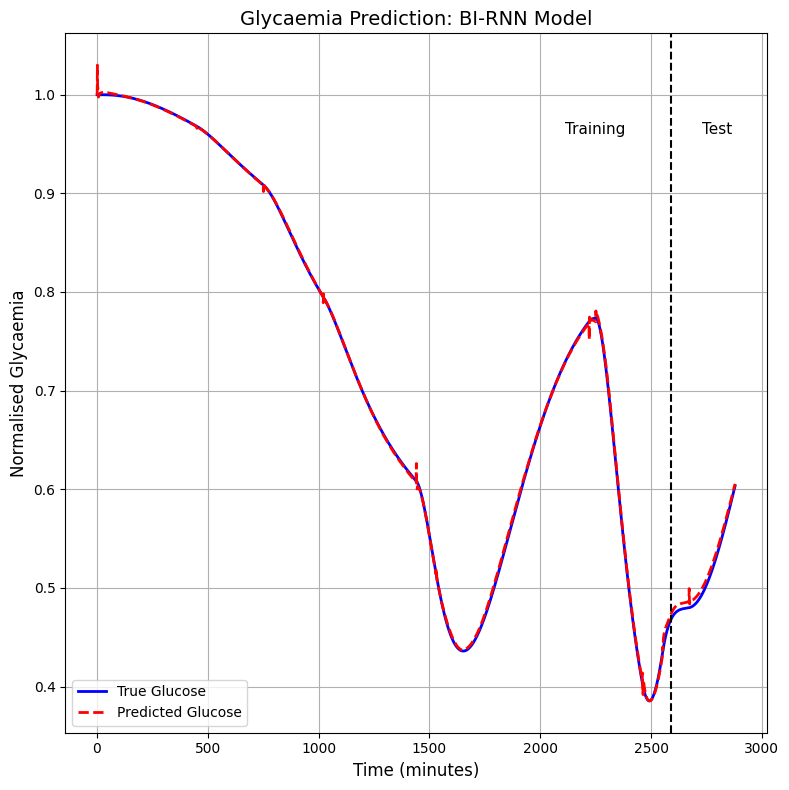

In [5]:
# === GRU Glucose Trace Plot with Train/Test Split ===

# Extract glucose only (index 0), rescale if needed
G_pred_gru = predicted_full[0, :, 0]
G_true_gru = true_full[0, 1:, 0]
time_gru = time_full

# Split index for 90% training
split_index = int(0.9 * len(G_true_gru))
split_time = time_gru[split_index]

plt.figure(figsize=(8, 8))
plt.plot(time_gru, G_true_gru, label="True Glucose", color="blue", linewidth=2)
plt.plot(time_gru, G_pred_gru, label="Predicted Glucose", linestyle="--", color="red", linewidth=2)

# Add vertical dashed line at test/train split
plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
plt.text(2250, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)

# Labels and formatting
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Glycaemia", fontsize=12)
plt.title("Glycaemia Prediction: BI-RNN Model", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("glucose_prediction_GRU.png", dpi=600, bbox_inches='tight')
plt.show()


# **Forward**

In [7]:
from sklearn.metrics import mean_squared_error
import math

patients = list(range(2, 12))
num_runs = 5
num_epochs = 500
ksi_records = []

for pat in patients:
    for run in range(num_runs):
        print(f"\n=== Patient {pat} | Run {run + 1} / {num_runs} ===")

        # Load patient data
        filename = f"Pat{pat}.csv"
        df = pd.read_csv(filename)
        data_t = df.iloc[0:2880, [0]].values
        m_t = data_t.max()
        m_g = df.iloc[0:2880, [2]].values.max()
        m_i = df.iloc[0:2880, [3]].values.max()
        m_d = df.iloc[0:2880, [5]].values.max()

        # Build model_obj
        model_obj = GlucoseModel(pat, m_t, m_g, m_i, m_d)
        if inverse_activated:
            model_obj.set_inverse_parameters()
            initial_ksi = tf.exp(model_obj.log_ksi).numpy()
        else:
            model_obj.set_parameters(pat)
            initial_ksi = model_obj.ksi

        # --- 2. Retrieve sequences ---
        y_true = model_obj.get_ground_truth_sequence()
        u, r = model_obj.get_input_sequences()
        G_only = y_true[:, :-1, 0:1]
        Y_target = y_true[:, 1:, :]
        U_seq = u[:, :-1, :] / tf.reduce_max(u[:, :-1, :] + 1e-8)
        R_seq = r[:, :-1, :] / tf.reduce_max(r[:, :-1, :] + 1e-8)
        X_input = tf.concat([U_seq, R_seq, G_only], axis=-1)

        # --- 3. Train-test split ---
        T_total = X_input.shape[1]
        T_train = int(0.8 * T_total)

        X_train = X_input[:, :T_train, :]
        Y_train = Y_target[:, :T_train, :]
        U_train = U_seq[:, :T_train, :]
        R_train = R_seq[:, :T_train, :]

        X_test = X_input[:, T_train:, :]
        Y_test = Y_target[:, T_train:, :]

        # --- 4. Build model ---
        model = GRUDeCarliModel(hidden_units=96, num_layers=1, hard_ic=None)
        optimizer = Adam(learning_rate=1e-2)

        # === TRAIN ===
        for epoch in range(num_epochs):
            loss_val, lg, li, ld, lic, lb = train_step(X_train, Y_train, y_true[:, :T_train, :], U_train, R_train)
            if epoch % 50 == 0:
                tf.print("Epoch", epoch,
                         ": Total=", loss_val,
                         ", G=", lg,
                         ", I=", li,
                         ", D=", ld,
                         ", IC=", lic,
                         ", L_B=", lb)

        # === EVALUATE ===
        final_ksi = tf.exp(model_obj.log_ksi).numpy() if inverse_activated else model_obj.ksi
        Y_pred_full = model.predict(X_input)
        Y_true_full = Y_target.numpy()  # matches shape of Y_pred_full

        # Extract test region from full prediction
        G_pred = Y_pred_full[:, T_train:, 0]
        I_pred = Y_pred_full[:, T_train:, 1]
        D_pred = Y_pred_full[:, T_train:, 2]

        G_true = Y_true_full[:, T_train:, 0]
        I_true = Y_true_full[:, T_train:, 1]
        D_true = Y_true_full[:, T_train:, 2]

        rmse_g = math.sqrt(mean_squared_error(G_true.flatten(), G_pred.flatten()))
        rmse_i = math.sqrt(mean_squared_error(I_true.flatten(), I_pred.flatten()))
        rmse_d = math.sqrt(mean_squared_error(D_true.flatten(), D_pred.flatten()))

        ksi_records.append({
            "Patient": pat,
            "Run": run + 1,
            "Initial_ksi": float(initial_ksi),
            "Final_ksi": float(final_ksi),
            "RMSE_G": float(rmse_g),
            "RMSE_I": float(rmse_i),
            "RMSE_D": float(rmse_d)
        })

ksi_df = pd.DataFrame(ksi_records)
ksi_df.to_csv("gru_forward_estimates_all_patientsSYNTHETIC.csv", index=False)
print("\nSaved ksi estimates to 'gru_ksi_estimates_all_patients.csv'")


=== Patient 2 | Run 1 / 5 ===
Epoch 0 : Total= 6.76031685 , G= 0.656836748 , I= 0.0954500437 , D= 0.0683119744 , IC= 0.349651456 , L_B= 0.273438632
Epoch 50 : Total= 0.063827239 , G= 0.00073871325 , I= 0.0137401558 , D= 0.0200972557 , IC= 0.00519102579 , L_B= 0.0114358496
Epoch 100 : Total= 0.0415511914 , G= 3.11340045e-05 , I= 0.0124547845 , D= 0.0135093722 , IC= 1.07656715e-05 , L_B= 0.0085601313
Epoch 150 : Total= 0.0257025603 , G= 2.55521809e-05 , I= 0.0101401601 , D= 0.00599797349 , IC= 2.50959038e-05 , L_B= 0.00528262928
Epoch 200 : Total= 0.00277050724 , G= 5.61060115e-05 , I= 0.000713921618 , D= 0.000566836272 , IC= 0.000287349016 , L_B= 0.00044970811
Epoch 250 : Total= 0.000415537565 , G= 1.23804657e-05 , I= 0.000125560633 , D= 7.22996119e-05 , IC= 9.78861408e-07 , L_B= 6.54913456e-05
Epoch 300 : Total= 0.000222320101 , G= 5.27322845e-06 , I= 8.12335e-05 , D= 3.56390738e-05 , IC= 1.1346679e-07 , L_B= 3.73242656e-05
Epoch 350 : Total= 0.000160067852 , G= 3.15825628e-06 , I= 6.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

=== Patient 3 | Run 1 / 5 ===
Epoch 0 : Total= 5.46496 , G= 0.519554794 , I= 0.135507643 , D= 0.10219828 , IC= 0.171229139 , L_B= 0.252213746
Epoch 50 : Total= 0.125747591 , G= 0.000595486141 , I= 0.0346514657 , D= 0.0400798321 , IC= 0.000572189165 , L_B= 0.0250151288
Epoch 100 : Total= 0.0658403933 , G= 0.000176600122 , I= 0.0209792145 , D= 0.0190227907 , IC= 0.000114762202 , L_B= 0.0133422315
Epoch 150 : Total= 0.00813521631 , G= 1.43307207e-05 , I= 0.0012506895 , D= 0.00384364324 , IC= 2.35314092e-05 , L_B= 0.00165996
Epoch 200 : Total= 0.00453281309 , G= 7.66451467e-06 , I= 0.000876325532 , D= 0.00194995629 , IC= 1.89311706e-07 , L_B= 0.000926851761
Epoch 250 : Total= 0.00319402851 , G= 5.26373287e-06 , I= 0.000500373833 , D= 0.00148895488 , IC= 2.74087483e-07 , L_B= 0.00065331423
Epoch 300 : Total= 0.00240448257 , G= 4.28223302e-06 , I= 0.000272890204 , D= 0.00123116479 , IC= 1.35287493e-07 , L_B= 0.000491296174
Epoch 350 : Total= 0.00249746

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

=== Patient 3 | Run 2 / 5 ===
Epoch 0 : Total= 5.96544456 , G= 0.560373664 , I= 0.194747299 , D= 0.106424376 , IC= 0.183061942 , L_B= 0.286950737
Epoch 50 : Total= 0.125771716 , G= 0.000530819583 , I= 0.0339620784 , D= 0.0404800549 , IC= 0.00263363589 , L_B= 0.0249013323
Epoch 100 : Total= 0.0685928 , G= 0.00024891147 , I= 0.0243060905 , D= 0.016959846 , IC= 9.53946655e-05 , L_B= 0.0137949428
Epoch 150 : Total= 0.00831286609 , G= 6.49438e-05 , I= 0.0011251329 , D= 0.00385194 , IC= 4.64593904e-05 , L_B= 0.00161031517
Epoch 200 : Total= 0.00435099239 , G= 3.02747885e-05 , I= 0.000710495398 , D= 0.00189539732 , IC= 3.88372246e-06 , L_B= 0.000851252815
Epoch 250 : Total= 0.00251148175 , G= 1.07516098e-05 , I= 0.000267796742 , D= 0.00127118896 , IC= 7.07716424e-07 , L_B= 0.000502681651
Epoch 300 : Total= 0.00188184786 , G= 6.19841148e-06 , I= 0.000131179972 , D= 0.00104409852 , IC= 4.3675837e-07 , L_B= 0.000379750069
Epoch 350 : Total= 0.00173181656 ,

In [9]:
ksi_df = pd.DataFrame(ksi_records)
ksi_df.to_csv("gru_forward_estimates_all_patientsSYNTHETIC.csv", index=False)
print("\nSaved ksi estimates to 'gru_ksi_estimates_all_patients.csv'")


Saved ksi estimates to 'gru_ksi_estimates_all_patients.csv'


# **Inverse**

In [8]:
patients = list(range(2, 12))
num_runs = 5
ksi_records = []

for pat in patients:
    for run in range(num_runs):
        print(f"\n=== Patient {pat} | Run {run + 1} / {num_runs} ===")

        # Load patient data
        filename = f"Pat{pat}.csv"
        df = pd.read_csv(filename)
        data_t = df.iloc[0:2880, [0]].values
        m_t = data_t.max()

        m_g = df.iloc[0:2880, [2]].values.max()
        m_i = df.iloc[0:2880, [3]].values.max()
        m_d = df.iloc[0:2880, [5]].values.max()

        # Build model_obj
        model_obj = GlucoseModel(pat, m_t, m_g, m_i, m_d)
        if inverse_activated:
            inverse_vars = model_obj.set_inverse_parameters()
        else:
            model_obj.set_parameters(pat)

        initial_ksi = tf.exp(model_obj.log_ksi).numpy() if inverse_activated else model_obj.ksi

        # --- 2. Retrieve sequences ---
        y_true = model_obj.get_ground_truth_sequence()
        u, r = model_obj.get_input_sequences()
        G_only = y_true[:, :-1, 0:1]  # only glucose
        Y_target = y_true[:, 1:, :]
        U_seq = u[:, :-1, :] / tf.reduce_max(u[:, :-1, :] + 1e-8)
        R_seq = r[:, :-1, :] / tf.reduce_max(r[:, :-1, :] + 1e-8)

        X_input = tf.concat([U_seq, R_seq, G_only], axis=-1)

        # --- 3. Train-test split ---
        T_total = X_input.shape[1]
        T_train = int(0.8 * T_total)

        X_train = X_input[:, :T_train, :]
        Y_train = Y_target[:, :T_train, :]
        U_train = U_seq[:, :T_train, :]
        R_train = R_seq[:, :T_train, :]

        X_test = X_input[:, T_train:, :]
        Y_test = Y_target[:, T_train:, :]
        u_test = U_seq[:, T_train:, :]
        r_test = R_seq[:, T_train:, :]

        # --- 4. Build model ---
        # hard_ic = y_true[:, 0:1, :]  # shape [1, 1, 3]
        hard_ic = None
        model = GRUDeCarliModel(hidden_units=96, num_layers=1, hard_ic=hard_ic)
        optimizer = Adam(learning_rate=1e-3)

        stage_configs = [
            (1e-2, dict(lambda_g=1.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.0, lambda_B=0.0), 500),
            (5e-3, dict(lambda_g=8.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.53, lambda_B=4.82), 800),
            (5e-4, dict(lambda_g=8.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.53, lambda_B=4.82), 600),
        ]

        ksi_values = []

        for stage, (lr, lambdas, epochs) in enumerate(stage_configs):
            print(f"\n=== Stage {stage + 1} | LR={lr}, Epochs={epochs} ===")
            optimizer.learning_rate.assign(lr)
            lambda_g = lambdas["lambda_g"]
            lambda_i = lambdas["lambda_i"]
            lambda_d = lambdas["lambda_d"]
            lambda_ic = lambdas["lambda_ic"]
            lambda_B = lambdas["lambda_B"]

            # Freeze inverse parameters if desired
            if inverse_activated:
                inverse_vars = [model_obj.log_ksi]
            else:
                inverse_vars = []

            for epoch in range(epochs):
                loss_val, lg, li, ld, lic, lb = train_step(
                    X_train, Y_train, y_true[:, :T_train, :], U_train, R_train
                )

                if inverse_activated:
                    ksi_values.append(tf.exp(model_obj.log_ksi).numpy())

                if epoch % 50 == 0:
                    tf.print(f"[Stage {stage+1} | Epoch {epoch}]",
                            "Total=", loss_val,
                            ", G=", lg,
                            ", I=", li,
                            ", D=", ld,
                            ", IC=", lic,
                            ", L_B=", lb)

        final_ksi = tf.exp(model_obj.log_ksi).numpy() if inverse_activated else model_obj.ksi
        ksi_records.append({
            "Patient": pat,
            "Run": run + 1,
            "Initial_ksi": initial_ksi,
            "Final_ksi": final_ksi
        })



=== Patient 2 | Run 1 / 5 ===

=== Stage 1 | LR=0.01, Epochs=500 ===
[Stage 1 | Epoch 0] Total= 0.430840254 , G= 0.430840254 , I= 0.0488914847 , D= 0.06204997 , IC= 0.283932298 , L_B= 0.180526495
[Stage 1 | Epoch 50] Total= 0.000279630738 , G= 0.000279630738 , I= 0.084869 , D= 0.0744298 , IC= 0.00389918569 , L_B= 0.0530284233
[Stage 1 | Epoch 100] Total= 1.33705935e-05 , G= 1.33705935e-05 , I= 0.0852269456 , D= 0.0751706883 , IC= 0.00202335604 , L_B= 0.0533040613
[Stage 1 | Epoch 150] Total= 8.86889e-06 , G= 8.86889e-06 , I= 0.0853030756 , D= 0.0751664862 , IC= 0.00109098316 , L_B= 0.0533265695
[Stage 1 | Epoch 200] Total= 7.08038579e-06 , G= 7.08038579e-06 , I= 0.0852965042 , D= 0.0751211941 , IC= 0.000553454913 , L_B= 0.053308744
[Stage 1 | Epoch 250] Total= 5.96739392e-06 , G= 5.96739392e-06 , I= 0.0852586925 , D= 0.07505963 , IC= 0.000368341105 , L_B= 0.0532753468
[Stage 1 | Epoch 300] Total= 5.15469765e-06 , G= 5.15469765e-06 , I= 0.0852106363 , D= 0.0749904 , IC= 0.000293698453 

In [10]:
ksi_df = pd.DataFrame(ksi_records)
ksi_df.to_csv("gru_ksi_estimates_all_patients.csv", index=False)
print("\nSaved ksi estimates to 'gru_ksi_estimates_all_patients.csv'")



Saved ksi estimates to 'gru_ksi_estimates_all_patients.csv'


# **Bayesian Optimisation**

In [10]:
import optuna
import tensorflow as tf
import numpy as np

# === Objective Function for Optuna ===
def objective(trial):
    tf.keras.backend.clear_session()

    # --- Sample Loss Weights ---
    lambda_g = trial.suggest_float("lambda_g", 0.0, 10.0)
    lambda_ic = trial.suggest_float("lambda_ic", 0.0, 10.0)
    lambda_B = trial.suggest_float("lambda_B", 0.0, 10.0)

    # Fix others
    lambda_i = 0.0
    lambda_d = 0.0

    # --- Reset Glucose Model ---
    model_obj = GlucoseModel(pat, m_t, m_g, m_i, m_d)
    inverse_activated = False
    if inverse_activated:
        model_obj.set_inverse_parameters()
    else:
        model_obj.set_parameters(pat)

    # --- Build Model ---
    model = GRUDeCarliModel(hidden_units=96, num_layers=1, hard_ic=None)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # --- Train Step Wrapper ---
    def train_step(x, y_true, y_in, u, r):
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)

            if model.hard_ic is not None:
                loss_ic = 0.0
            else:
                ic_true = y_true[:, 0:1, :]
                ic_pred = y_pred[:, 0:1, :]
                loss_ic = tf.reduce_mean(tf.square(ic_true - ic_pred))

            loss_g = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0]))
            loss_i = tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))
            loss_d = tf.reduce_mean(tf.square(y_true[:, :, 2] - y_pred[:, :, 2]))

            loss_bio = compute_bio_residual_loss(y_pred, y_in, U_train, R_train, dt=1.0 / m_t)

            loss = (
                lambda_g * loss_g +
                lambda_i * loss_i +
                lambda_d * loss_d +
                lambda_ic * loss_ic +
                lambda_B * loss_bio
            )

        variables = model.trainable_variables
        if inverse_activated:
            variables += [model_obj.log_ksi]
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))

        return loss

    # --- Run for a Few Epochs ---
    for epoch in range(200):  # Small trial for speed
        train_step(X_train, Y_train, y_true[:, :T_train, :], U_train, R_train)

    # --- Evaluate Glucose RMSE ---
    pred_test = model(X_test, training=False).numpy()
    rmse_G = np.sqrt(np.mean((pred_test[0, :, 0] - Y_test[0, :, 0]) ** 2))

    return rmse_G  # Minimize this

# === Run Study ===
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

# === Output Best Weights ===
best_lambdas = study.best_params
print("Best Loss Weights:")
print(best_lambdas)


[I 2025-06-04 21:48:03,832] A new study created in memory with name: no-name-315e29f9-b5c8-4cc8-9288-f69acd501f78
[I 2025-06-04 21:48:25,179] Trial 0 finished with value: 0.05877288058400154 and parameters: {'lambda_g': 0.6434330855947578, 'lambda_ic': 8.054402433773975, 'lambda_B': 5.081690664873566}. Best is trial 0 with value: 0.05877288058400154.
[I 2025-06-04 21:48:46,507] Trial 1 finished with value: 0.03254292532801628 and parameters: {'lambda_g': 0.8082290359304883, 'lambda_ic': 5.694951824510648, 'lambda_B': 7.032923165603629}. Best is trial 1 with value: 0.03254292532801628.
[I 2025-06-04 21:49:07,846] Trial 2 finished with value: 0.04479169100522995 and parameters: {'lambda_g': 0.8440262932594573, 'lambda_ic': 1.9609197950796964, 'lambda_B': 8.900607024828842}. Best is trial 1 with value: 0.03254292532801628.
[I 2025-06-04 21:49:29,168] Trial 3 finished with value: 0.2517757713794708 and parameters: {'lambda_g': 0.1864914586508284, 'lambda_ic': 0.5674638877683524, 'lambda_B'

Best Loss Weights:
{'lambda_g': 0.790143042551918, 'lambda_ic': 9.842348970564318, 'lambda_B': 1.322511861253553}
